In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, ConciseDateFormatter
from matplotlib.ticker import MaxNLocator, FuncFormatter, MultipleLocator
import seaborn as sns
import os
from glob import glob
import measures as msp
from matplotlib.colors import ListedColormap

gpath = '<path to data>'
doctype = 'preprints'

In [25]:
genders = {1:'Female',0:'Male'} # gender alphabetically ordered
intervals = {0:[0,1], 1:[1,4], 2:[4,10], 3:[10,999]} #seniority bands
mks = ['X','d','s','*']  #markers seniority
clrs = ['#e66101','#fdb863','#b2abd2','#5e3c99'] # colours seniority
cmap = ListedColormap(['#e66101','#fdb863','#b2abd2','#5e3c99'])

mks_g = {'Female':'^', 'Male':'o'} #markers gender
clrs_g = {'Female':'#fc8d62', 'Male':'#66c2a5'} #colours gender
ms=6  #marker size
sns.set(style='ticks', font_scale=1.2, font='Arial')  #overall style and font

savefig = True

In [3]:
files = sorted(glob(gpath+'/preprints/preprints*.csv'))

# join all files (separeted per year)
pieces = []
for path in files:
    df_temp = pd.read_csv(path)
    # Apply bands to SciAge
    df_temp['Seniority'] = df_temp.ScientificAge.apply(lambda x: msp.assign_bands(x,intervals))
    df_temp['Date'] = pd.to_datetime(df_temp['Date']).dt.to_period("M")
    pieces.append(df_temp[df_temp['Gender']!=-1])
    allData = pd.concat(pieces, ignore_index=True)
allData.head(3)

,PaperId,AuthorId,Date,Gender,ScientificAge,CountryCode,Seniority
0,3105624533,2031085308,2010-09,0,1.375342,ES,1-4
1,3105894348,2297360158,2010-05,0,8.421918,IT,4-10
2,2027104606,2619972786,2010-10,0,20.827396,PL,10-999


In [4]:
period = 5
sys_prod = msp.compute_sys_productivity(allData,
                                        period,
                                        '2015-07',
                                        '2021-07',
                                        genders,
                                        intervals) # +1m > open righ, as in range()

In [5]:
df = pd.DataFrame(sys_prod[1:], columns=sys_prod[0])
df['Date'] = pd.to_datetime(df['Date']).dt.to_period("M")
df.head(3)

,Date,All,Female,Male,0-1,1-4,4-10,10-999
0,2015-07,1.429371,1.307994,1.452081,1.126758,1.288412,1.414387,1.572888
1,2015-08,1.420861,1.303956,1.442940,1.124223,1.290085,1.412998,1.558113
2,2015-09,1.423208,1.307594,1.445061,1.121394,1.292283,1.417981,1.560570


# Plot System Productivity

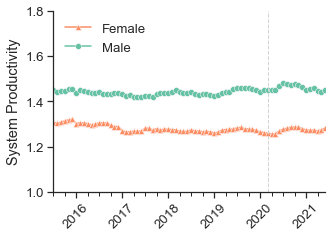

In [6]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)
for k,v in genders.items():
    df.plot(x='Date', y=v, label=v, ax=axs, marker=mks_g[v], ms=ms, color=clrs_g[v],
            markeredgecolor='snow', markeredgewidth=0.5)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('System Productivity')
axs.set_xlabel('')
axs.tick_params(axis='x', labelrotation=45)
plt.legend(frameon=False)
axs.set_ylim(1, 1.8)
sns.despine()
if savefig:
    plt.savefig(f'figs/Sys_productivity_{doctype}_gender_.pdf', dpi=300)
plt.show()

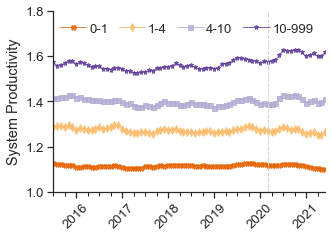

In [7]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)

for k,v in intervals.items():
    band = f'{v[0]}-{v[1]}'
    df.plot(x='Date', y=band, label=band, ax=axs, marker=mks[k], ms=ms-1, color=clrs[k], alpha=0.8, linewidth=1)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('System Productivity')
axs.set_xlabel('')
axs.set_ylim(1, 1.8)
axs.tick_params(axis='x', labelrotation=45)
plt.legend(ncol=4, frameon=False, columnspacing=0.8,handletextpad=0.2)
sns.despine()
if savefig:
    plt.savefig(f'figs/Sys_productivity_{doctype}_seniority.pdf', dpi=300)
plt.show()

# Authorships

In [140]:
window = allData[allData.Date > '2014-12']
groups = window.groupby(['Date','Gender'])['PaperId'].size().reset_index(name='Authorships')

inset = allData[allData.Date > '2018-12']
male = (inset[inset.Gender==0].groupby('Date')['PaperId'].size() / \
        inset.groupby('Date')['PaperId'].size()).reset_index(name='Male')

female = (inset[inset.Gender==1].groupby('Date')['PaperId'].size() / \
        inset.groupby('Date')['PaperId'].size()).reset_index(name='Female')

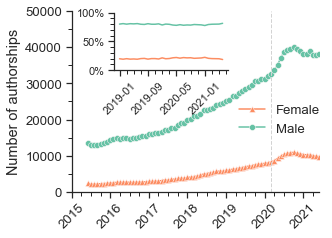

In [141]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)

for k,v in genders.items():
    groups[groups['Gender']==k] \
    .rolling(6, on='Date').mean()\
    .plot(x='Date', y='Authorships', label=v, ax=axs, marker=mks_g[v], ms=ms, color=clrs_g[v],
            markeredgecolor='snow', markeredgewidth=0.5)
axs.set_ylabel('Number of authorships')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylim(0, 50000)
axs.set_xlabel('')
axs.tick_params(axis='x', labelrotation=45)
axs.yaxis.set_major_locator(MaxNLocator(6))
axs.yaxis.set_minor_locator(MultipleLocator(5000))
axs.legend(loc='center right', frameon=False, bbox_to_anchor=(1.05, 0.4))

left, bottom, width, height = [0.34, 0.71, 0.35, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(female.Date.astype(str), female.Female, label='Female',color=clrs_g['Female'])
ax2.plot(male.Date.astype(str), male.Male, label='Male',color=clrs_g['Male'])
#female.rolling(6, on='Date').mean().plot(x='Date', y='Female', ax=ax2, color=clrs_g['Female'])
#male.rolling(6, on='Date').mean().plot(x='Date', y='Male', ax=ax2, color=clrs_g['Male'])
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax2.xaxis.set_minor_locator(MultipleLocator(2))
ax2.xaxis.set_major_locator(MaxNLocator(4))


ax2.legend().set_visible(False)

ax2.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='both', labelsize=11)
ax2.locator_params("y", nbins=3)
ax2.set_ylim(0, 1)
ax2.set_xlabel('')

sns.despine()
if savefig:
    plt.savefig(f'figs/authorships_{doctype}_gender.pdf')
plt.show()

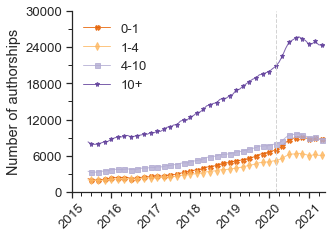

In [111]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)

groups_S = window.groupby(['Date','Seniority'])['PaperId'].size().reset_index(name='Authorships')
for k,v in intervals.items():
    band = f'{v[0]}-{v[1]}'
    label = band
    if '999' in band:
        label = band.replace('-999','+')
    groups_S[groups_S['Seniority']==band] \
    .rolling(6, on='Date').mean()\
    .plot(x='Date', y='Authorships', label=label, 
          ax=axs, marker=mks[k], ms=ms-1, color=clrs[k], alpha=0.8, linewidth=1, markevery=2)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('Number of authorships')
axs.set_ylim(0, 30000)
axs.yaxis.set_major_locator(MaxNLocator(5))
axs.yaxis.set_minor_locator(MultipleLocator(3000))
axs.tick_params(axis='x', labelrotation=45)
axs.set_xlabel('') 
axs.legend(loc='upper left', frameon=False)


sns.despine()
if savefig:
    plt.savefig(f'figs/authorships_{doctype}_seniority.pdf')
plt.show()

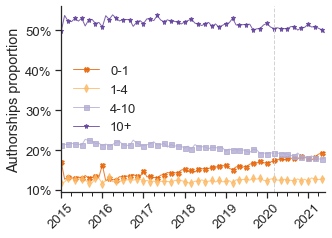

In [163]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)

for k,v in intervals.items():
    band = f'{v[0]}-{v[1]}'
    label = band
    if '999' in band:
        label = band.replace('-999','+')
    s_band = (window[window.Seniority==band].groupby('Date')['PaperId'].size() / \
        window.groupby('Date')['PaperId'].size()).reset_index(name='Authorships')
    s_band.plot(x='Date', y='Authorships', label=label, 
          ax=axs, marker=mks[k], ms=ms-1, color=clrs[k], alpha=0.8, linewidth=1, markevery=2)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('Authorships proportion')
#axs.set_ylim(0.1, 0.6)
axs.yaxis.set_major_locator(MaxNLocator(5))
axs.yaxis.set_minor_locator(MultipleLocator(5))
axs.tick_params(axis='x', labelrotation=45)
axs.set_xlabel('') 
axs.legend(loc='center left', frameon=False)
axs.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
#axs.annotate('a)', xy=(0.007, 0.92), xycoords='figure fraction', fontsize=17, weight='bold')

sns.despine()
if savefig:
    plt.savefig(f'figs/authorships_{doctype}_seniority_proportion.pdf')
plt.show()

# Preprints drill down

In [53]:
nrepo = allData[allData.Date > '2014-12'].groupby('Date')['PaperId'] \
        .nunique() \
        .reset_index(name='Preprints')

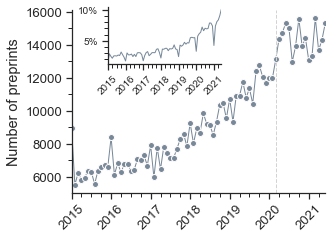

In [78]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)

ratio = pd.read_csv(gpath+'/RatiopreprintstoAll.csv')
ratio['Date'] = pd.to_datetime(ratio['Date']).dt.to_period("M")
ratio = ratio[ratio.Date >= '2015-01']

nrepo.plot(x='Date', y='Preprints', ax=axs, marker='o', ms=ms, legend=False,
           color='lightslategrey',markeredgecolor='snow',markeredgewidth=1, linewidth=1)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('Number of preprints')
axs.set_xlabel('')
axs.tick_params(axis='x', labelrotation=45)
axs.yaxis.set_minor_locator(MultipleLocator(1000))

left, bottom, width, height = [0.32, 0.74, 0.35, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ratio.plot(x='Date', y='Proportion', ax=ax2, legend=False, fontsize=10, color='lightslategrey', linewidth=1)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xlabel('')
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax2.yaxis.set_minor_locator(MultipleLocator(0.01))

sns.despine()
if savefig:
    plt.savefig(f'figs/number_preprints_{doctype}.pdf', dpi=300)
plt.show()

# New authors drill down

In [58]:
new_auth = allData[(allData.ScientificAge < 0.00001) & (allData.Date > '2014-12')]
new_authors = new_auth.groupby('Date')['AuthorId'] \
                      .nunique() \
                      .reset_index(name='New Authors')
new_auth_inset = new_auth[new_auth.Date > '2018-12']

male = (new_auth_inset[new_auth_inset.Gender==0].groupby('Date')['AuthorId'].nunique() / \
        new_auth_inset.groupby('Date')['AuthorId'].nunique()).reset_index(name='Male')
female = (new_auth_inset[new_auth_inset.Gender==1].groupby('Date')['AuthorId'].nunique() / \
          new_auth_inset.groupby('Date')['AuthorId'].nunique()).reset_index(name='Female')

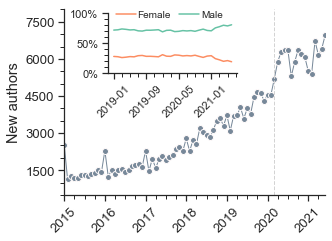

In [89]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)

new_authors.plot(x='Date', y='New Authors', ax=axs, marker='o', ms=ms, legend=False,
                   color='lightslategrey',markeredgecolor='snow',markeredgewidth=1, linewidth=1)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('New authors')
axs.set_xlabel('')
axs.tick_params(axis='x', labelrotation=45)
axs.yaxis.set_major_locator(MaxNLocator(6))
axs.yaxis.set_minor_locator(MultipleLocator(500))
axs.set_ylim(500, 8000)

left, bottom, width, height = [0.32, 0.71, 0.4, 0.26]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(female.Date.astype(str), female.Female, label='Female',color=clrs_g['Female'])
ax2.plot(male.Date.astype(str), male.Male, label='Male',color=clrs_g['Male'])
ax2.legend(loc='upper left',bbox_to_anchor=(-0.01, 1.2), ncol=2, frameon=False, fontsize=10, 
           columnspacing=0.8,handletextpad=0.2)
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax2.xaxis.set_minor_locator(MultipleLocator(2))
ax2.xaxis.set_major_locator(MaxNLocator(4))

ax2.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='both', labelsize=11)
ax2.locator_params("y", nbins=3)
ax2.set_xlabel('')
ax2.set_ylim(0,1)

sns.despine()
if savefig:
    plt.savefig(f'figs/new_authors_{doctype}.pdf', dpi=300)
plt.show()

# Plot Individual productivity

In [91]:
period = 5
ind_prod = msp.compute_ind_productivity(allData,
                                        period,
                                        '2015-07',
                                        '2021-07',
                                        genders,
                                        intervals) # +1m > open righ, as in range()

In [92]:
dfi = pd.DataFrame(ind_prod[1:], columns=ind_prod[0])
#df.to_csv(gpath+'/DATA/productivity/Ind_productivity_Alldocs_nonundefined.csv')
dfi['Date'] = pd.to_datetime(dfi['Date']).dt.to_period("M")
dfi.head(3)

,Date,All,Female,Male,0-1,1-4,4-10,10-999
0,2015-07,0.315378,0.247932,0.330533,0.135940,0.219425,0.304803,0.408670
1,2015-08,0.328144,0.259161,0.343761,0.136786,0.219951,0.305796,0.451857
2,2015-09,0.327449,0.258822,0.343005,0.136264,0.216440,0.307370,0.451252


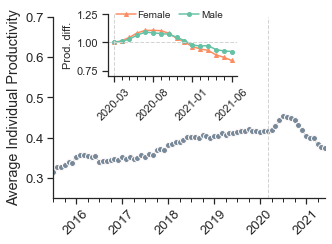

In [105]:
fig, axs = plt.subplots(figsize=(4.5,3.2), constrained_layout=True)

dfi.plot(x='Date', y='All', ax=axs, marker='o', ms=ms, legend=False,
       color='lightslategrey',markeredgecolor='snow',markeredgewidth=1, linewidth=1)
axs.set_ylabel('Average Individual Productivity')
axs.set_xlabel('')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylim(0.25, 0.7)
axs.tick_params(axis='x', labelrotation=45)
ax2.yaxis.set_major_locator(MaxNLocator(6))


left, bottom, width, height = [0.32, 0.71, 0.4, 0.27]
ax = fig.add_axes([left, bottom, width, height])
df_t = dfi.loc[dfi.Date > '2020-02', ['Date','Male','Female']].copy()

for i,col in enumerate(sorted(df_t.columns[1:])):
    ref = df_t[df_t['Date']=='2020-03'][col].values
    df_t[col] = df_t[col] / ref
    ax.plot(df_t['Date'].astype(str), df_t[col],marker=mks_g[col], label=col, ms=ms-2, color=clrs_g[col])

ax.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
ax.axhline(y=1, color='lightgrey', lw=1, ls='--')
ax.legend(loc='upper left',bbox_to_anchor=(-0.01, 1.2), ncol=2, frameon=False,
          fontsize=10,columnspacing=0.8,handletextpad=0.2)

ax.set_ylabel('Prod. diff.', fontsize=11)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='both', labelsize=11)
ax.set_ylim(0.7, 1.25)
ax.set_xlabel('')

sns.despine()
if savefig:
    plt.savefig(f'figs/Ind_productivity_{doctype}_gender.pdf', dpi=300)
plt.show()

In [172]:
dfi[dfi.All == dfi.All.max()], dfi[dfi.Date == '2020-03']

(       Date       All    Female      Male       0-1       1-4      4-10  \
 60  2020-07  0.453113  0.394676  0.471888  0.243288  0.317586  0.398271   
 
       10-999  
 60  0.606365  ,
        Date       All    Female      Male       0-1       1-4      4-10  \
 56  2020-03  0.415244  0.357217  0.433112  0.221088  0.292007  0.363467   
 
       10-999  
 56  0.552861  )